# (WIP) 08. PyTorch Paper Replicating

Want to recreate ViT paper: "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" - https://arxiv.org/abs/2010.11929 

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt 

In [2]:
# Set seeds
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 1. Get Data

In [3]:


# assert int(torch.__version__.split(".")[1]) >= 13

# Make transform, let's get bigger images
img_size = 224
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor()
])

# Start with CIFAR10
train_data = torchvision.datasets.CIFAR10(root="data",
                                          train=True,
                                          transform=transform,
                                          download=True)

test_data = torchvision.datasets.CIFAR10(root="data",
                                         train=False,
                                         transform=transform,
                                         download=True)

train_data, test_data

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
            ))

In [5]:
import os
os.cpu_count() // 2

8

In [6]:
# Create dataloaders
import os
batch_size = 128
num_workers = os.cpu_count() // 2
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=num_workers) 

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=num_workers)

len(train_dataloader), len(test_dataloader)

(391, 79)

In [7]:
class_names = train_data.classes
image, label = train_data[0][0], train_data[0][1]
image.shape, label, class_names

(torch.Size([3, 224, 224]),
 6,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

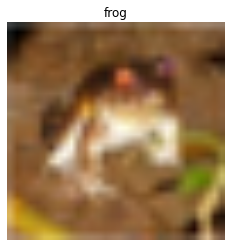

In [8]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False); 

## 2. Split data into patches

Want to visualize the data and see if it can be split into patches with a Conv2D layer.

See Figure 1 - the image gets embedded into patches, that's what I want to create

Also section 3.1:

> To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer.

To handle 2D images, we reshape the image `x` (HxWxC) -> `x` (Nx(P^2•C)) where:
* (H, W) is the resolution of the original image
* C is the number of channels
* (P, P) is the resolution of each patch
* N = HW/P^2

Patch size from paper: "ViT-L/16 means the “Large” variant with 16×16 input patch size"

Let's say I want patches of 16x16, I want a Conv2d with:
* in_channels=3 (number of channels)
* out_channels=D (number of hidden units)
* kernel=patch_size (make the kernel the patch)
* padding="same" (want to keep the same dimensions of the input as the output)
* stride=patch_size (stride the size of the patch)

In [9]:
# Example of calculating N
height, width = img_size, img_size
patch_size = 16
N = (height * width) / patch_size ** 2
N

196.0

In [10]:
# Example of calculating output shape
16**2 * 3

768

In [11]:
from torch import nn
patch_size=16

# Create the embedding and the patch in one hit 
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

flatten = nn.Flatten(start_dim=2, 
                     end_dim=3) # https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html 

In [12]:
# Now we have a patchified image of 256 tokens + an embedding for each patch
patch_image_out_of_conv = conv2d(image.unsqueeze(0))
print(patch_image_out_of_conv.shape)
patch_image = flatten(conv2d(image.unsqueeze(0)))
patch_image.shape

torch.Size([1, 768, 14, 14])


torch.Size([1, 768, 196])

In [13]:
# Get image in shape [batch_size, N, P^2*C]
patch_image.transpose(-2, -1).shape

torch.Size([1, 196, 768])

In [14]:
# Get image in shape [batch_size, N, P^2*C]
patch_image.permute(0, 2, 1).shape

torch.Size([1, 196, 768])

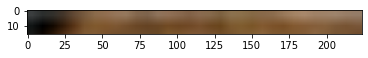

In [15]:
# Color channels, height, width
# Want the top row
plt.imshow(image[:, :patch_size, :].permute(1, 2, 0));

In [16]:
patch_size**2

256

In [17]:
img_size//patch_size

14

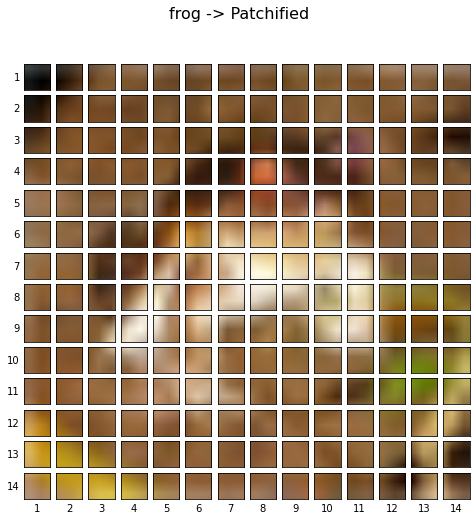

In [18]:
patch_size = 16
assert image.shape[1] % patch_size == 0, "Image size must be divisble by patch size." 

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size, # need int not float
                        ncols=img_size//patch_size, 
                        figsize=(patch_size/2, patch_size/2),
                        sharex=True,
                        sharey=True)

# Go from (C, H, W) -> (H, W, C) for matplotlib 
image_permuted = image.permute(1, 2, 0)
for i, patch_h in enumerate(range(0, img_size, patch_size)):
    for j, patch_w in enumerate(range(0, img_size, patch_size)):
        # Plot coordinates = (i, j)
        # print(f"On patch: {i+1}, {j+1}")
        
        # Plot the permuted image (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_h:patch_h+patch_size, # iterate through height 
                                        patch_w:patch_w+patch_size, # iterate through width
                                        :]) # get all color channels
        
        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### Create patching layer

In [19]:
class Patching(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 embedding_dim=768,
                ):
        super().__init__()
        
        self.patcher = nn.Sequential(
            nn.Conv2d(in_channels, 
                      embedding_dim,
                      kernel_size=patch_size,
                      stride=patch_size),
            nn.Flatten(2, 3))

    def forward(self, x):
        return self.patcher(x).permute(0, 2, 1) # [batch_size, P^2*C, N] -> [batch_size, N, P^2*C] 
    
patcher = Patching(in_channels=3,
                   patch_size=16,
                   embedding_dim=768)

patched_image = patcher(image.unsqueeze(0))
patched_image.shape

torch.Size([1, 196, 768])

In [20]:
patched_image

tensor([[[-0.0493, -0.0303, -0.0467,  ..., -0.0579,  0.0741,  0.0175],
         [ 0.0479, -0.0500, -0.0985,  ...,  0.0104,  0.1262,  0.0950],
         [ 0.0056, -0.1374, -0.1498,  ..., -0.0190,  0.2522,  0.0952],
         ...,
         [-0.0591, -0.0718, -0.0976,  ..., -0.0793,  0.2160, -0.0108],
         [ 0.0803, -0.1643, -0.1503,  ...,  0.0571,  0.3753,  0.1394],
         [-0.1072, -0.0928, -0.0877,  ..., -0.0869,  0.2486, -0.0469]]],
       grad_fn=<PermuteBackward0>)

## Replicate the model

Do the replication in the order of the paper says.

Or just take the graphic and build it up layer by layer.

### Create feedforward model

> Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings. 

> The MLP contains two layers with a GELU non-linearity

$$
\begin{aligned}
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L
\end{aligned}
$$ 

In [21]:
class FeedForward(nn.Module):
    """Creates feed foward layer of MLP"""
    def __init__(self,
                 in_features,
                 out_features,
                 dropout=0):
        super().__init__()
        
        self.feedforward = nn.Sequential(
            nn.Linear(in_features=in_features,
                      out_features=out_features),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=out_features,
                      out_features=in_features),
            nn.Dropout(p=dropout))
        
    def forward(self, x):
        return self.feedforward(x)

### Create MSA (Multihead Self-Attention)

See docs - https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

Heads = 12 

In [22]:
class MSABlock(nn.Module):
    """Creates a multi-head self-attention block: https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html"""
    def __init__(self,
                 embed_dim,
                 num_heads=12,
                 attn_dropout=0):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, 
                                                    num_heads, 
                                                    dropout=0,
                                                    batch_first=True) # (batch, seq, feature)
        
    def forward(self, x):
        attn_output, _ = self.multihead_attn(query=x,
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [23]:
patched_image.shape

torch.Size([1, 196, 768])

In [24]:
msa_block = MSABlock(embed_dim=768, num_heads=12)
msa_block(patched_image).shape

torch.Size([1, 196, 768])

### Create transformer block


In [25]:
class TransformerBlock(nn.Module):
    """Creates a transformer block as a combination of Norm, MSA and MLPs."""
    def __init__(self,
                 embed_dim=768,
                 num_heads=12,
                 feedforward_dropout=0.1,
                 attn_dropout=0, 
                 feedforward_hidden=3072):
        super().__init__()
        
        # Create attention norm
        self.attn_norm = nn.LayerNorm(embed_dim)
        
        # Create feedforward norm
        self.feedforward_norm = nn.LayerNorm(embed_dim)
        
        # Create attention block
        self.attn_block = nn.Sequential(
            self.attn_norm,
            MSABlock(embed_dim,
                     num_heads,
                     attn_dropout))
        
        # Create feedforward block
        self.feedforward_block = nn.Sequential(
            self.feedforward_norm,
            FeedForward(embed_dim,
                        feedforward_hidden,
                        feedforward_dropout))
    
    def forward(self, x):
        x = self.attn_block(x) + x # add in skip connections
        x = self.feedforward_block(x) + x 
        return x     

### Create ViT

Combine the transformer blocks and patched embedding into a ViT architecture.

In [26]:
class ViT(nn.Module):
    def __init__(self,
                 img_size=224,
                 in_channels=3,
                 patch_size=16,
                 embed_dim=768,
                 embed_dropout=0.1,
                 num_blocks=12,
                 num_heads=12,
                 feedforward_dropout=0.1,
                 attn_dropout=0,
                 feedforward_hidden=3072,
                 num_classes=10):
        super().__init__()
        
        # TK - make assertion about patch size and image size
        
        # Get image size
        self.image_height, self.image_width = img_size, img_size
        
        # Create embedding dropout
        self.embed_dropout = nn.Dropout(p=embed_dropout)
        
        # Calculate number of patches
        self.num_patches = (self.image_height * self.image_width) // patch_size**2
        
        # Create pos embedding (from index 1 -> last of patch embedding size)
        self.position_embedding = nn.Parameter(data=torch.randn(1, 
                                                                self.num_patches+1, 
                                                                embed_dim),
                                               requires_grad=True)
                 
        # Create class embed (needs to go at front of sequence embedding)
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embed_dim),
                                            requires_grad=True)
        
        # Create patching layer
        self.patcher = Patching(in_channels=in_channels,
                                patch_size=16,
                                embedding_dim=embed_dim)
        
        # Create transformer blocks
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(embed_dim=embed_dim,
                                                                   num_heads=num_heads,
                                                                   feedforward_dropout=feedforward_dropout,
                                                                   attn_dropout=attn_dropout,
                                                                   feedforward_hidden=feedforward_hidden) for _ in range(num_blocks)])
        
        # Create classifier head 
        self.classifier = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, num_classes)
        )
        
    def forward(self, x):
        # Create patches of input
        x = self.patcher(x)

        # Expand class_embeddings to be all of the batch size
        batch_size = x.shape[0] # get batch size
        class_tokens = self.class_embedding.expand(batch_size, -1, -1) # want one class_embedding per sample in the batch 

        # Add class embedding to front of patch embeddings
        x = torch.cat((class_tokens, x), dim=1)

        # Add positional embedding 
        x = x + self.position_embedding

        # Perform embedding dropout
        x = self.embed_dropout(x)
        
        # Put x through Transformer blocks
        x = self.transformer_blocks(x)

        # Put x through classifier layer (only the class token)
        x = self.classifier(x[:, 0])

        return x

In [27]:
set_seeds()
device = "cuda" if torch.cuda.is_available() else "cpu"
rand_image = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes=10)
vit(rand_image)

tensor([[ 0.8556,  0.8625,  0.0721,  0.2553, -0.5083,  0.1817, -0.8376,  0.2771,
         -0.6463,  0.6173]], grad_fn=<AddmmBackward0>)

In [28]:
from torchinfo import summary

# TK - clean up the summary so it looks nice when it prints out 
# Print a summary using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(128, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                     Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                                   [128, 3, 224, 224]   [128, 10]            152,064              True
├─Dropout (embed_dropout)                                                   [128, 197, 768]      [128, 197, 768]      --                   --
├─Patching (patcher)                                                        [128, 3, 224, 224]   [128, 196, 768]      --                   True
│    └─Sequential (patcher)                                                 [128, 3, 224, 224]   [128, 768, 196]      --                   True
│    │    └─Conv2d (0)                                                      [128, 3, 224, 224]   [128, 768, 14, 14]   590,592              True
│    │    └─Flatten (1)                                                     [128, 768, 14, 14]   [128, 768, 196]      --             

* TK - same number of parameters as: https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 -> 86567656

In [29]:
batch_size = 32
cls_embedding = nn.Parameter(torch.randn(1, 1, 768))
# See here: https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html
cls_embedding.shape, cls_embedding.expand(batch_size, -1, -1).shape

(torch.Size([1, 1, 768]), torch.Size([32, 1, 768]))

## Train model

In [ ]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# # ViT takes about 10 mins per epoch on NVIDIA TITAN RTX with batch_size=128 (can't go too high otherwise CUDA errors)
# before pin_memory=True & num_workers=2
# 100%
# 5/5 [49:12<00:00, 592.45s/it]
# Epoch: 1 | train_loss: 2.2422 | train_acc: 0.1651 | test_loss: 1.9800 | test_acc: 0.2674
# Epoch: 2 | train_loss: 1.9293 | train_acc: 0.2822 | test_loss: 1.8700 | test_acc: 0.3182
# Epoch: 3 | train_loss: 1.8806 | train_acc: 0.3047 | test_loss: 1.8414 | test_acc: 0.3228
# Epoch: 4 | train_loss: 1.8261 | train_acc: 0.3320 | test_loss: 1.8285 | test_acc: 0.3274
# Epoch: 5 | train_loss: 1.8110 | train_acc: 0.3376 | test_loss: 1.8469 | test_acc: 0.3336

# # after pin_memory=True & num_workers=2
# 100%
# 5/5 [46:09<00:00, 552.48s/it]
# Epoch: 1 | train_loss: 2.2506 | train_acc: 0.1605 | test_loss: 1.9786 | test_acc: 0.2625
# Epoch: 2 | train_loss: 2.0066 | train_acc: 0.2601 | test_loss: 1.9614 | test_acc: 0.2857
# Epoch: 3 | train_loss: 1.9130 | train_acc: 0.2972 | test_loss: 1.8789 | test_acc: 0.3068
# Epoch: 4 | train_loss: 1.9281 | train_acc: 0.2923 | test_loss: 1.9277 | test_acc: 0.2904
# Epoch: 5 | train_loss: 1.8675 | train_acc: 0.3148 | test_loss: 1.8407 | test_acc: 0.3094

# # after pin_memory=True & num_workers=os.cpu_count() // 2 & non_blocking=True
# 100%





In [27]:
!nvidia-smi

Tue Jun 14 10:59:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:01:00.0 Off |                  N/A |
| 40%   51C    P8     9W / 280W |   3110MiB / 24217MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [114]:
torch.cuda.max_memory_allocated() / 1024

15904270.5

In [116]:
torch.cuda.empty_cache()

In [118]:
!nvidia-smi

Tue Jun 14 10:03:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN RTX    Off  | 00000000:01:00.0 Off |                  N/A |
| 41%   30C    P8     6W / 280W |  23980MiB / 24217MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Bring in pretrained ViT from `torchvision.models` on same dataset 

* Get a similar model from here - https://pytorch.org/vision/main/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16 

In [42]:
import torch
import torchvision

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [44]:
# Set seeds
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [45]:
# Requires torchvision >= 0.13
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [46]:
# Create dataset for pretrained ViT
import torch
import torchvision
import matplotlib.pyplot as plt 

# # Make transform, let's get bigger images
# img_size = 224
# transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((img_size, img_size)),
#     torchvision.transforms.ToTensor()
# ])

# Requires torchvision >= 0.13
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
vit_transforms = weights.transforms()

# Start with CIFAR10
train_data = torchvision.datasets.CIFAR10(root="data",
                                          train=True,
                                          transform=vit_transforms,
                                          download=True)

test_data = torchvision.datasets.CIFAR10(root="data",
                                         train=False,
                                         transform=vit_transforms,
                                         download=True)

# Get class names
class_names = train_data.classes
print(f"Class names: {class_names}")

# Create dataloaders
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=2) 

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=2)

len(train_dataloader), len(test_dataloader)

Files already downloaded and verified
Files already downloaded and verified
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


(391, 79)

In [47]:
# Train feature extractor ViT for 5 epochs on CIFAR10
# TK - can probably increase the batch_size here because we're using feature extraction and not 
# training the whole model
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
results = engine.train(model=pretrained_vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2860 | train_acc: 0.9218 | test_loss: 0.1840 | test_acc: 0.9413
Epoch: 2 | train_loss: 0.1579 | train_acc: 0.9480 | test_loss: 0.1665 | test_acc: 0.9458
Epoch: 3 | train_loss: 0.1386 | train_acc: 0.9554 | test_loss: 0.1578 | test_acc: 0.9486
Epoch: 4 | train_loss: 0.1270 | train_acc: 0.9585 | test_loss: 0.1537 | test_acc: 0.9500
Epoch: 5 | train_loss: 0.1189 | train_acc: 0.9610 | test_loss: 0.1522 | test_acc: 0.9498


In [ ]:
# # Feature extractor results before pin_memory=True and num_workers=2
# 100%
# 5/5 [21:34<00:00, 259.41s/it]
# Epoch: 1 | train_loss: 0.2860 | train_acc: 0.9202 | test_loss: 0.1841 | test_acc: 0.9430
# Epoch: 2 | train_loss: 0.1584 | train_acc: 0.9486 | test_loss: 0.1658 | test_acc: 0.9455
# Epoch: 3 | train_loss: 0.1381 | train_acc: 0.9551 | test_loss: 0.1584 | test_acc: 0.9479
# Epoch: 4 | train_loss: 0.1271 | train_acc: 0.9582 | test_loss: 0.1532 | test_acc: 0.9487
# Epoch: 5 | train_loss: 0.1193 | train_acc: 0.9606 | test_loss: 0.1525 | test_acc: 0.9498

# # Results after pin_memory=True and num_workers=2
# 100%
# 5/5 [17:57<00:00, 215.69s/it]
# Epoch: 1 | train_loss: 0.2860 | train_acc: 0.9218 | test_loss: 0.1840 | test_acc: 0.9413
# Epoch: 2 | train_loss: 0.1579 | train_acc: 0.9480 | test_loss: 0.1665 | test_acc: 0.9458
# Epoch: 3 | train_loss: 0.1386 | train_acc: 0.9554 | test_loss: 0.1578 | test_acc: 0.9486
# Epoch: 4 | train_loss: 0.1270 | train_acc: 0.9585 | test_loss: 0.1537 | test_acc: 0.9500
# Epoch: 5 | train_loss: 0.1189 | train_acc: 0.9610 | test_loss: 0.1522 | test_acc: 0.9498

## TK - Exercises

## TK - Extra-curriculum

* See the illustrated transformer for an overview of the Transformer model:  https://jalammar.github.io/illustrated-transformer/